# Radial Profile Analysis with S-PLUS data

In this workshop, we will explore how to create radial profiles from astronomical images and normalize them by annular areas to obtain surface brightness profiles. 

We will use data from the S-PLUS survey and photutils for handling the image processing and analysis. The main goal is to walk through the steps of extracting the radial profile from an astronomical image, calibrating the profile, and converting it into magnitudes.

Key topics covered:
1. Loading and visualizing images.
2. Applying circular apertures to images.
3. Extracting radial profiles.
4. Calibrating and converting profiles into magnitudes.

In [1]:
import splusdata

## Connecting to S-PLUS and Querying Images
We first connect to the S-PLUS database and retrieve image data for a specific RA/DEC position. The `lupton_rgb` function generates an RGB image, which is useful for visual inspection. 

The target coordinates are:
- RA: 54.6210
- DEC: -35.4505

In [2]:
conn = splusdata.Core()

In [22]:
ra = 54.6210
dec = -35.4505

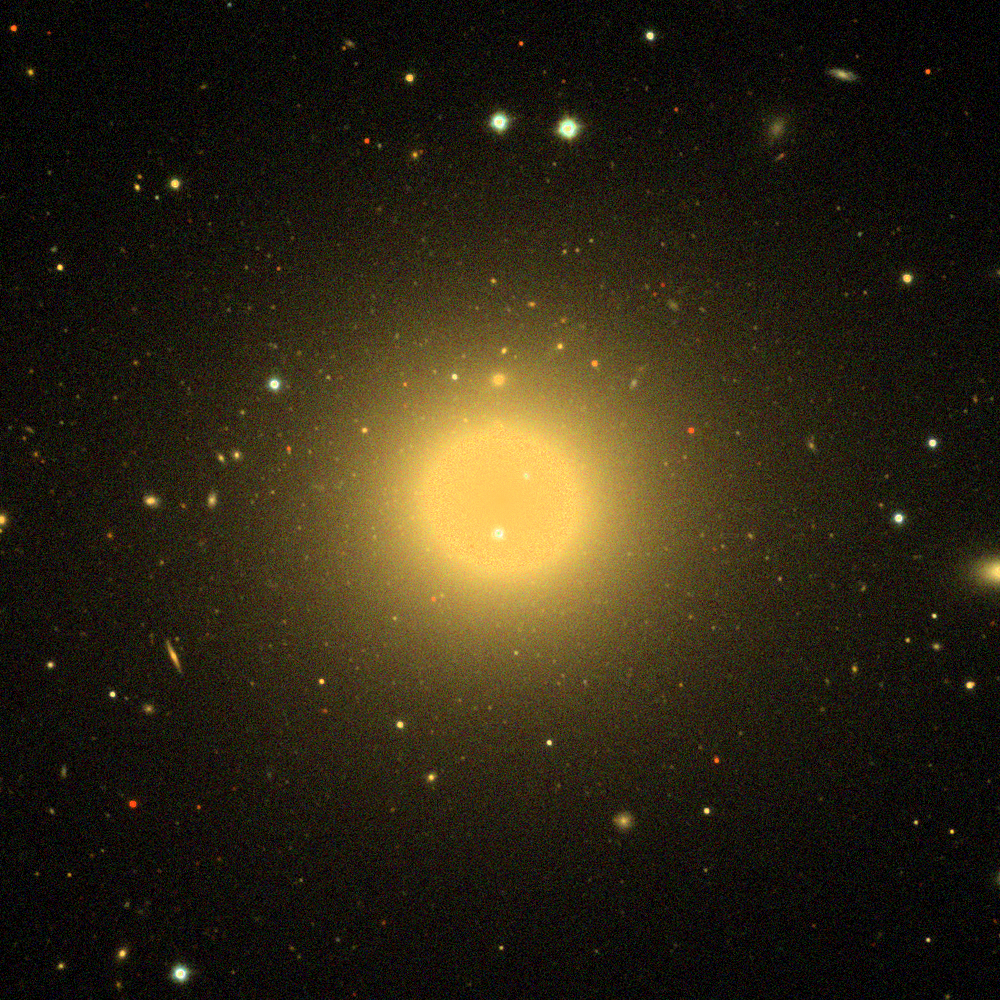

In [33]:
conn.lupton_rgb(ra, dec, 1000)

## Plotting Circular Apertures Over Image
In this section, we define a function to overlay circular apertures on the image. Circular apertures are useful for photometry and visualizing how the radial profile will be extracted. The radii of these apertures can be customized to match the size of the objects in the image.
- We scale the image data using percentile values (default: [0.1, 99.7]) to improve the visibility of features.

In [28]:
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture
import numpy as np

def plot_aper_over_image(data, aperture_radius = [], zscale = [0.1, 99.7]):
    """
    Plots an image with circular apertures overlaid.
    Parameters:
        data (numpy.ndarray): 2D array representing the image data.
        aperture_radius (list, optional): List of radii for the circular apertures in pixels to be plotted. Default is an empty list.
        zscale (list, optional): List containing two values that define the percentile range for scaling the image display. Default is [0.1, 99.7].

    """
    vmin, vmax = np.percentile(data, zscale)
    plt.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    
    center_y, center_x = np.array(data.shape) // 2
    for aper_radius in aperture_radius:
        aperture = CircularAperture((center_x, center_y), r=aper_radius)
        aperture.plot(color='red', lw=1)
    
    plt.show()

In [31]:
stamp = conn.stamp(ra, dec, size = 1000, band = "R")
print(stamp)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x322a6d040>, <astropy.io.fits.hdu.compressed.compressed.CompImageHDU object at 0x322a79100>]


In [51]:
data = stamp[1].data

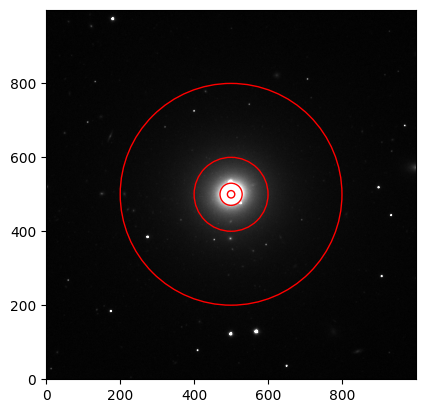

In [160]:
plot_aper_over_image(data, aperture_radius = [10, 30, 100, 300], zscale=[1, 99.7])

## Centroid Calculation Using Quadratic Interpolation
To ensure the radial profile is centered correctly, we calculate the centroid of the target object in the image using a quadratic centroiding method. This improves the accuracy of our analysis by aligning the center of the apertures with the object of interest.

In [53]:
from photutils.centroids import centroid_quadratic

xycen = centroid_quadratic(data, xpeak=500, ypeak=500, search_boxsize=[51, 51])
xycen

array([501.43610636, 500.83200864])

## Defining Radial Bins for the Radial Profile
We define radial bins (or annuli) using `np.arange` to set up the boundaries where the radial profile will be calculated. The bins start from the center of the object and extend outward.

In [89]:
edge_radii = np.arange(150, step=0.5)
edge_radii

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,

## Fetching Error Maps for Error Propagation
Here, we also fetch the associated error map for the image data to accurately propagate the errors in our radial profile. The error map is essential to quantify uncertainties in the measurements.

In [162]:
error = conn.stamp(ra, dec, size = 1000, band = "R", weight=True)
error = error[1].data

## Creating the Radial Profile
We create a radial profile using the `RadialProfile` function, which measures the flux within concentric annuli at the calculated centroid. This step provides both the profile values and their associated errors.

In [163]:
from photutils.profiles import RadialProfile

rp = RadialProfile(data, xycen, edge_radii, mask=None, error=error)

In [201]:
print("FWHM of the Gaussian fit:\n", rp.gaussian_fwhm, "\n")
print("First 10 radius:\n", rp.radius[:10], "\n")
print("First 10 profile values:\n", rp.profile[:10], "\n")
print("First 10 values of the radial profile error:\n", rp.profile_error[:10], "\n")

FWHM of the Gaussian fit:
 17.578134453525088 

First 10 radius:
 [0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75] 

First 10 profile values:
 [332.12037478 327.75028654 315.91087079 302.61512107 284.64655817
 267.92189576 249.32866655 232.60749464 215.85223437 201.42169686] 

First 10 values of the radial profile error:
 [25.20953767 14.54889225 11.27451591  9.52851477  8.39823913  7.59300572
  6.98278763  6.49968854  6.10431397  5.7739509 ] 



## Plotting the Radial Profile with Error Bars
We plot the radial profile as a function of radius, including error bars to visualize the uncertainty.

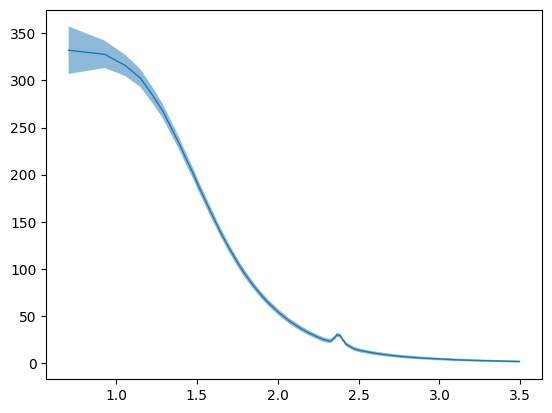

In [228]:
plt.plot(rp.radius ** 0.25, rp.profile, lw=1)
plt.fill_between(rp.radius ** 0.25, rp.profile - rp.profile_error, rp.profile + rp.profile_error, alpha=0.5)

plt.show()

## Normalizing the Radial Profile by Annular Areas
The radial profile needs to be normalized by the area of each annulus to obtain the surface brightness profile. This is done by calculating the area of each annulus and dividing the profile values by their respective areas.

In [229]:
# Calculate the areas of the annular bins
r_inner = edge_radii[:-1]  # inner radii
r_outer = edge_radii[1:]  # outer radii
annular_areas = np.pi * (r_outer**2 - r_inner**2)

print("First 10 Annular Areas: ", annular_areas[0:10], "...")

First 10 Annular Areas:  [ 0.78539816  2.35619449  3.92699082  5.49778714  7.06858347  8.6393798
 10.21017612 11.78097245 13.35176878 14.9225651 ] ...


In [230]:
# Normalize the radial profile by the areas
calibrated_profile = rp.profile / annular_areas

# Propagate the error by dividing the original error by the area
calibrated_error = rp.profile_error / annular_areas

## Calibrating
We then get the zero point values from splus and convert the calibrated radial profile from flux (or intensity) to magnitudes using the standard conversion formula. The zero-point magnitude is added to align the profile with physical magnitudes. 

Zero points values are available always in the documentation, check for example:

https://splus.cloud/documentation/DR4?Auxiliary_Tables

In [237]:
import pandas as pd
# Fetch the zero-points from the S-PLUS documentation
zps = pd.read_csv("https://splus.cloud/files/documentation/iDR4/tabelas/iDR4_zero-points.csv")
zps

,Field,RA,DEC,ZP_u,ZP_J0378,ZP_J0395,ZP_J0410,ZP_J0430,ZP_g,ZP_J0515,ZP_r,ZP_J0660,ZP_i,ZP_J0861,ZP_z
0,HYDRA-0011,150.77,-23.91,19.978,19.217,19.283,20.346,20.511,22.781,20.719,22.710,20.207,22.488,20.757,21.904
1,HYDRA-0012,152.31,-23.91,20.824,20.049,20.073,21.092,21.220,23.569,21.506,23.573,21.096,23.361,21.624,22.781
2,HYDRA-0013,153.85,-23.91,20.850,20.058,20.069,21.108,21.225,23.569,21.502,23.558,21.084,23.344,21.606,22.771
3,HYDRA-0014,155.38,-23.91,20.775,19.981,19.994,20.990,21.087,23.436,21.376,23.478,21.006,23.288,21.579,22.685
4,HYDRA-0015,156.93,-23.91,20.903,20.074,20.070,21.112,21.256,23.589,21.505,23.525,20.982,23.303,21.389,22.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,STRIPE82-0166,355.75,0.70,20.908,19.969,19.977,21.106,21.199,23.553,21.126,23.527,21.082,23.342,21.619,22.732
1625,STRIPE82-0167,357.17,-0.70,20.096,19.312,19.408,20.494,20.669,22.914,20.792,22.779,20.267,22.547,20.807,21.974
1626,STRIPE82-0168,357.17,0.70,20.903,20.110,20.076,21.147,21.275,23.616,21.554,23.598,21.119,23.401,21.655,22.843
1627,STRIPE82-0169,358.58,-0.70,20.139,19.411,19.531,20.551,20.690,22.927,20.791,22.797,20.249,22.569,20.757,22.034


In [235]:
# Check the field of the coordinates
response = conn.checkcoords(ra, dec)
print("Field: ", response["field"])
print(response)

field_row = zps.loc[zps["Field"] == response["field"].replace("_", "-")]
print(display(field_row))

zp_value = field_row["ZP_r"].values[0]
print("Zero-point value: ", zp_value)

Field:  SPLUS_s27s34
{'field': 'SPLUS_s27s34', 'distance': 0.6547127, 'public': None, 'internal': 'idr3'}


,Field,RA,DEC,ZP_u,ZP_J0378,ZP_J0395,ZP_J0410,ZP_J0430,ZP_g,ZP_J0515,ZP_r,ZP_J0660,ZP_i,ZP_J0861,ZP_z
1156,SPLUS-s27s34,54.25,-34.87,20.891,20.167,20.169,21.16,21.277,23.59,21.522,23.586,21.096,23.383,21.633,22.832


None
Zero-point value:  23.586


In [233]:
# Convert calibrated profile to magnitudes and apply the zero-point
calibrated_magnitudes = -2.5 * np.log10(calibrated_profile) + zp_value

# Convert calibrated error to magnitudes
calibrated_error = 1.0857 * calibrated_error / calibrated_profile

print("First 10 Calibrated Magnitudes:\n", calibrated_magnitudes[0:10], "\n")
print("First 10 Calibrated Errors:\n", calibrated_error[0:10], "\n")

First 10 Calibrated Magnitudes:
 [17.02048591 18.22767014 18.82223829 19.23424324 19.57356613 19.8571859
 20.11665255 20.34739359 20.56445564 20.76034308] 

First 10 Calibrated Errors:
 [0.08240986 0.04819441 0.03874745 0.0341857  0.0320326  0.03076914
 0.0304065  0.03033742 0.03070366 0.03112266] 



## Plotting the Magnitude Profile
We plot the magnitude profile as a function of the radius.

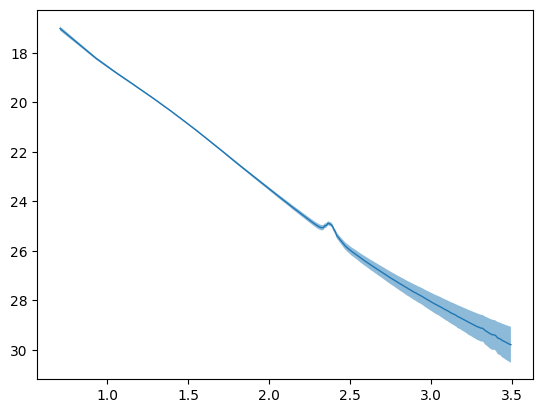

In [238]:
plt.plot(rp.radius ** 0.25, calibrated_magnitudes, lw=1)
plt.fill_between(rp.radius ** 0.25, calibrated_magnitudes - calibrated_error, calibrated_magnitudes + calibrated_error, alpha=0.5)

#invert the y-axis
plt.gca().invert_yaxis()

plt.show()

The de Vaucouleurs profile is commonly used to describe the surface brightness distribution of elliptical galaxies. It is given by the formula:


$$
I(r) \propto \exp\left(-k \, r^{1/4}\right)
$$

This means that when we plot the surface brightness profile against the radius raised to the power of \( r^{1/4} \), we expect a roughly linear relationship. 

